In [21]:
%matplotlib inline

In [22]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

'matplotlib'

In [23]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSION = "group13b_own"

In [24]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = RAW_DATA_PATH.joinpath(SESSION + ".vhdr"),
    eog = ("HEOG", "VEOG"),
    misc = ("41",),
    preload = True,
    verbose = False
)

raw.info

Measurement date,"February 29, 2024 14:40:42 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


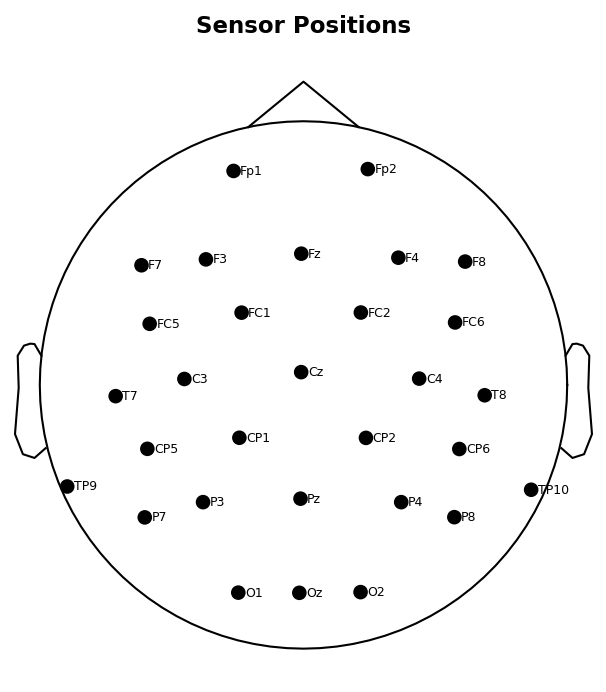

In [25]:
raw.set_montage(
    mne.channels.make_standard_montage("standard_1020"), 
    verbose=False
)
ax = raw.plot_sensors(
    show_names = True,
    sphere=(0, 0.02, 0, 0.1),
    show = False
).axes[0];
ax.set_title("Sensor Positions")
plt.sca(ax)
plt.show()

In [26]:
PLOT_SETTINGS = dict(
    n_channels=len(raw.ch_names),
    scalings=dict(
        eeg = 5e-5,
        misc = 2
    ),
    show = False,
)

Effective window size : 2.048 (s)


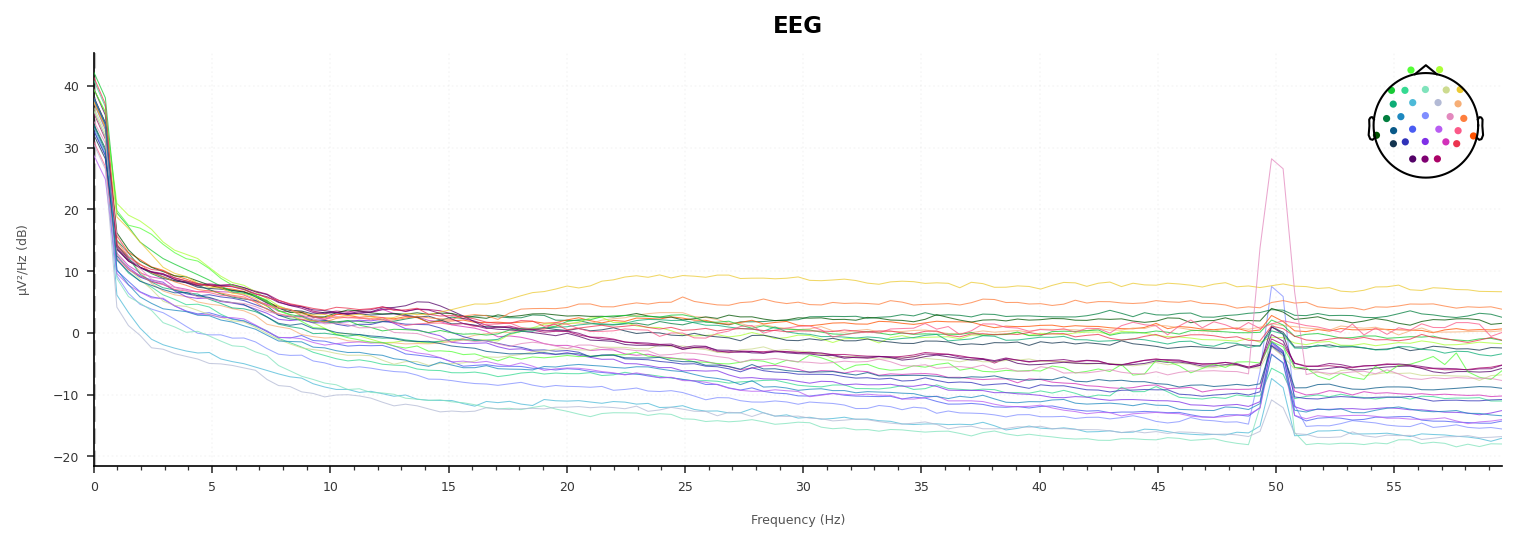

In [27]:
fig = raw.compute_psd(
    fmax=60,
    remove_dc=False,
).plot()
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))

In [28]:
preview_segmentation = dict(
    begin = 90,
    end = 120
)

raw_preview_segment = raw.copy().crop(
    tmin = preview_segmentation["begin"],
    tmax = preview_segmentation["end"],
)
# fig = raw_preview_segment.plot(
#     start = 0,
#     duration = preview_segmentation["end"] - preview_segmentation["begin"],
#     title = f"""Raw preview ({preview_segmentation["begin"]}s to {preview_segmentation["end"]}s)""",
#     show_scrollbars = False,
#     remove_dc = False,
#     **PLOT_SETTINGS
# )
# fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
# fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
# fig.set_size_inches(12, 10)
# plt.show()

In [29]:
raw_filtered = raw.copy()

raw_filtered.filter(
    l_freq = 1, # pass everything over _ Hz
    h_freq = 40, # pass everything below _ Hz
)

bad_channels = {
    "group13_own": [
        "F8",
        "T7",
        "T8",
        "TP10",
    ],
    "group13b_own": [
        "F8",
        "T7",
        "T8",
        "TP10",
    ],
}[SESSION]

raw_filtered.info["bads"] = bad_channels

raw_filtered.pick(
    picks=raw.ch_names, 
    exclude="bads"
)

fig = raw_filtered.plot(
    start = preview_segmentation["begin"],
    duration = preview_segmentation["end"] - preview_segmentation["begin"],
    **PLOT_SETTINGS
)
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_size_inches(12, 10)
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(
#     raw, 
#     h_freq = 2,
#     baseline=(-0.3, -0.1)
# )
# eog_epochs.average().plot_joint(title = "Electrooculography");

Fitting ICA to data using 26 channels (please be patient, this may take a while)


Selecting by explained variance: 6 components
Fitting ICA took 5.1s.


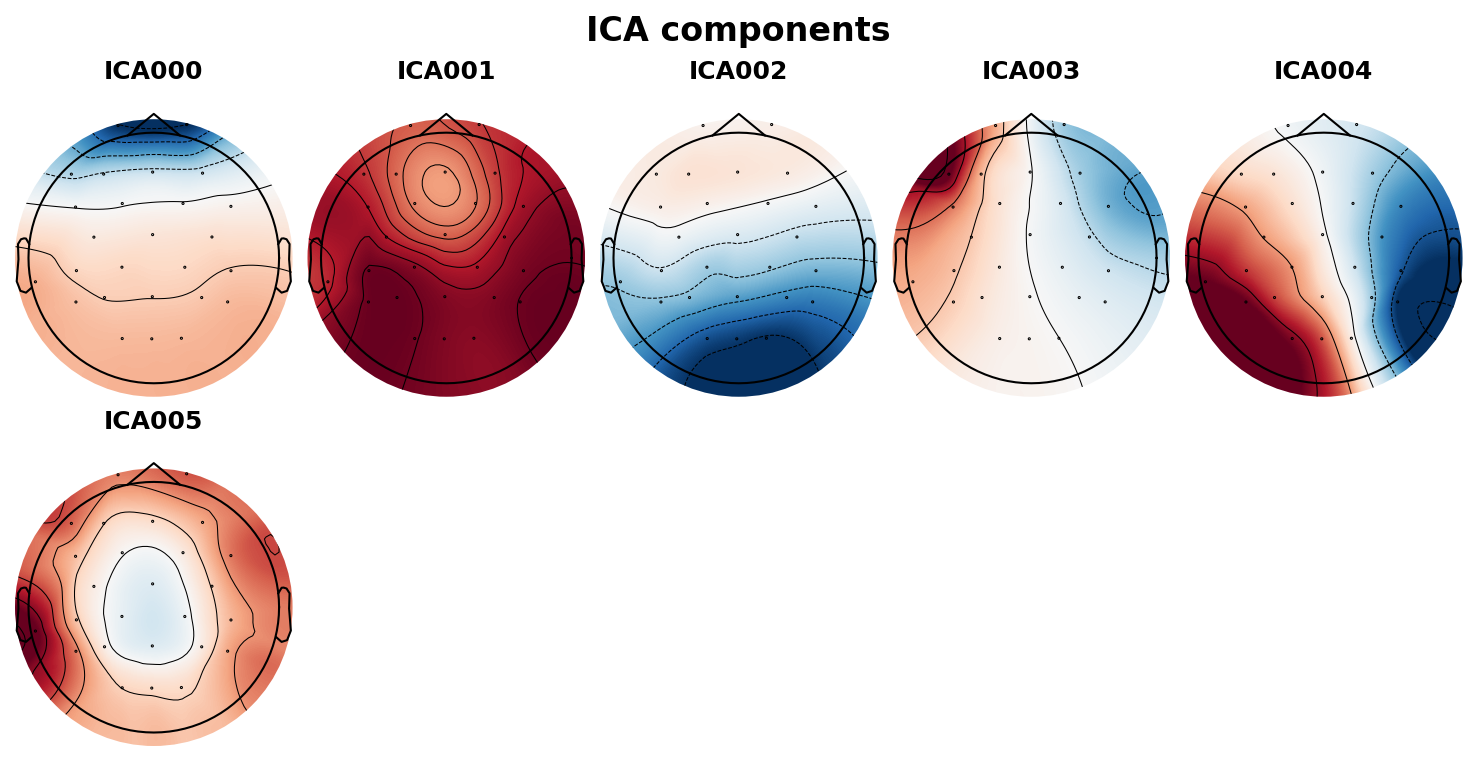

Creating RawArray with float64 data, n_channels=8, n_times=904900
    Range : 0 ... 904899 =      0.000 ...   904.899 secs
Ready.


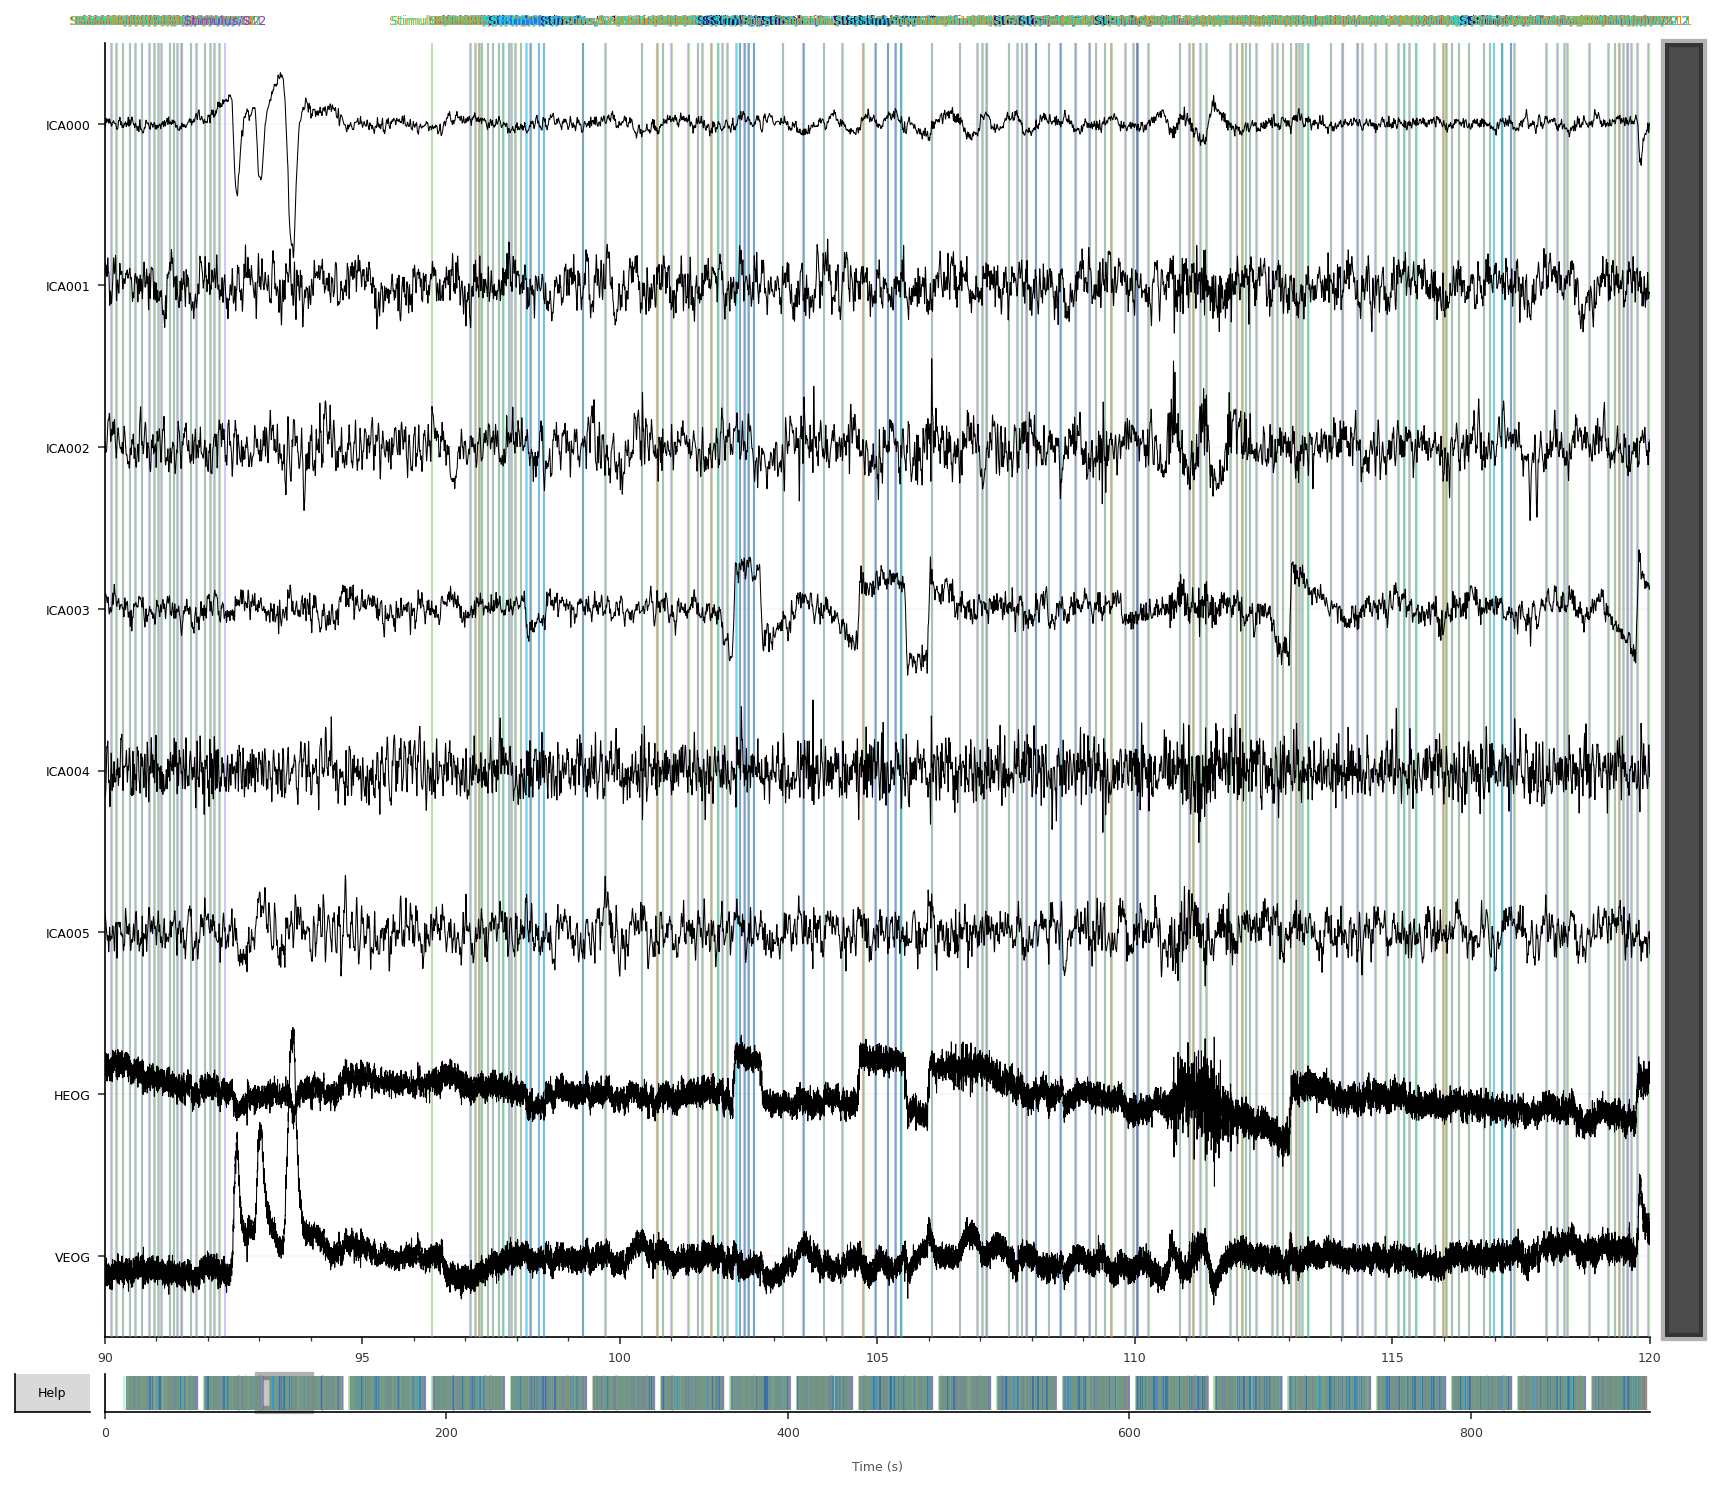

In [ ]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=0, max_iter=500)
ica.fit(raw_filtered)
ica.plot_components();
fig = ica.plot_sources(
    raw_filtered,
    start = preview_segmentation["begin"],
    stop = preview_segmentation["end"],
    show = False,
)
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_size_inches(12, 10)
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 2 ICA components
    Projecting back using 26 PCA components


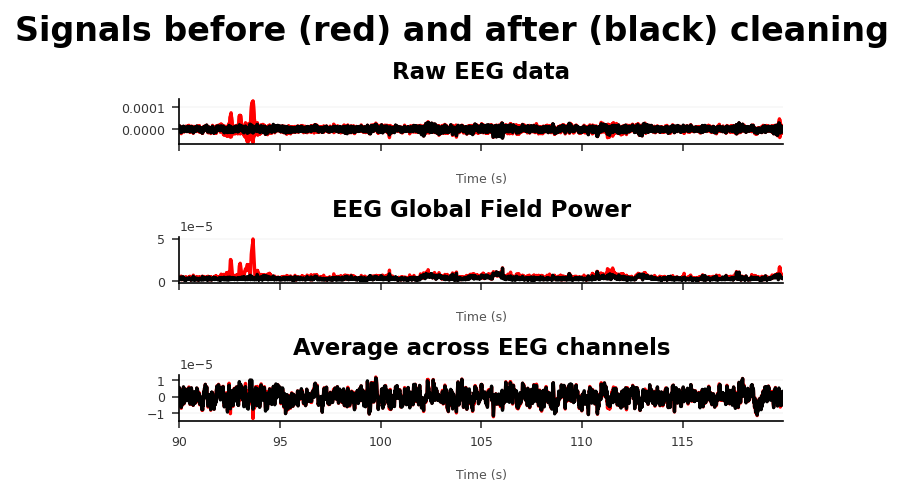

In [ ]:
artifact_ICAs = {
    "group13_own": [0, 4],
    "group13b_own": [0, 3],
}[SESSION]

fig = ica.plot_overlay(
    raw_filtered, 
    exclude=artifact_ICAs,
    start = preview_segmentation["begin"] * 1000,
    stop = preview_segmentation["end"] * 1000,
)

fig.axes[2].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[2].xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

In [ ]:
ica.exclude = artifact_ICAs
raw_processed = ica.apply(raw_filtered)

raw_processed.pick(["eeg"])

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 2 ICA components
    Projecting back using 26 PCA components


Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,26 EEG
Bad channels,"F8, T7, T8, TP10"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [ ]:
raw_processed.set_eeg_reference(
    "average", 
    projection=False, 
    verbose=False
)

Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,26 EEG
Bad channels,"F8, T7, T8, TP10"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


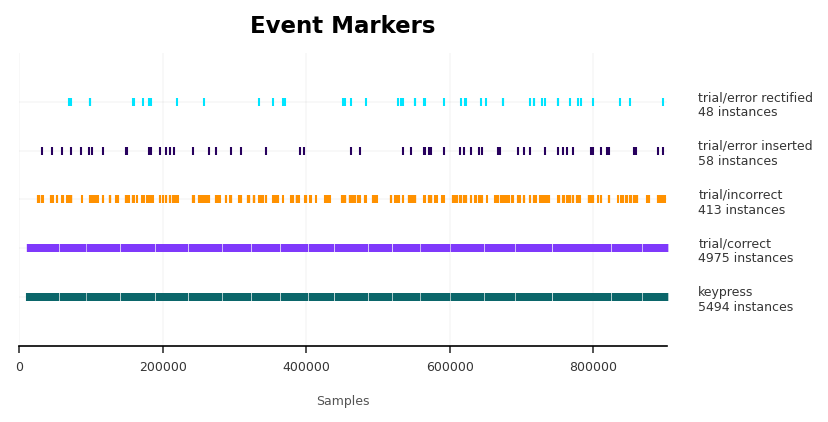

In [ ]:
import sys
sys.path.append("..")
from constants import EEG_EVENT_ENCODINGS

events, event_ids = mne.events_from_annotations(raw)

fig = mne.viz.plot_events(
    events, 
    event_id = EEG_EVENT_ENCODINGS,
    color = dict(),
    on_missing = "ignore",
    show = False,
    verbose = "ERROR"
)
fig.set_size_inches(9, 3)
ax = fig.axes[0]
for line in ax.get_lines():
    line.set_marker("|")
    line.set_markersize(4)

ax.get_legend().remove()
ax.set_yticklabels([f"{key}\n{(events[:,2] == code).sum()} instances" for key, code in EEG_EVENT_ENCODINGS.items()])
plt.tick_params(
    axis="y", 
    which="both", 
    labelleft = False, 
    labelright = True,
    length = 0,
    pad = 15
)
ax.set_ylabel("")
ax.spines["left"].set_visible(False)
ax.set_title("Event Markers")
plt.show()

In [ ]:
epochs = mne.Epochs(
    raw_processed, 
    events,
    event_id = EEG_EVENT_ENCODINGS, 
    picks = "eeg",
    reject = dict(eeg = 150e-6), 
    tmin = -0.2, 
    tmax = 0.6,
    baseline = (-0.2, 0),
    preload = True,
    verbose = False
)
epochs.info

Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,26 EEG
Bad channels,"F8, T7, T8, TP10"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [ ]:
print(f"{len([ep for ep in epochs.drop_log if len(ep)]) / len(events):.1%} of epochs were dropped")

33.3% of epochs were dropped


In [ ]:
def get_response_times(conditions):
    event_codes = [EEG_EVENT_ENCODINGS["trial/" + event] for event in conditions]
    trials = np.where(np.isin(events[:,2], event_codes))[0]
    response_times = events[trials + 1][:-1,0] - events[trials][:-1,0]
    response_times = np.append(response_times, np.median(response_times))
    return sorted(np.divide(response_times, 1000))

def plot_sanity_check(name, conditions, sensors):
    epochs[conditions].plot_image(
        picks = sensors,
        title = f"""{name} ({", ".join(sensors)})\nConditional on Response Time""",
        overlay_times = get_response_times(conditions = conditions),
    )[0];

# plot_sanity_check(
#     name = "Positive Feedback",
#     conditions = ["correct", "error rectified"], 
#     sensors = ["O2"]
# )

# plot_sanity_check(
#     name = "Negative Feedback",
#     conditions = ["incorrect", "error inserted"], 
#     sensors = ["O2"]
# )

# plot_sanity_check(
#     name = "Negative Feedback",
#     conditions = ["incorrect", "error inserted"], 
#     sensors = ["T7"]
# )

# plot_sanity_check(
#     name = "Inserted Errors",
#     conditions = ["error inserted"], 
#     sensors = ["Cz"]
# )

No projector specified for this dataset. Please consider the method self.add_proj.


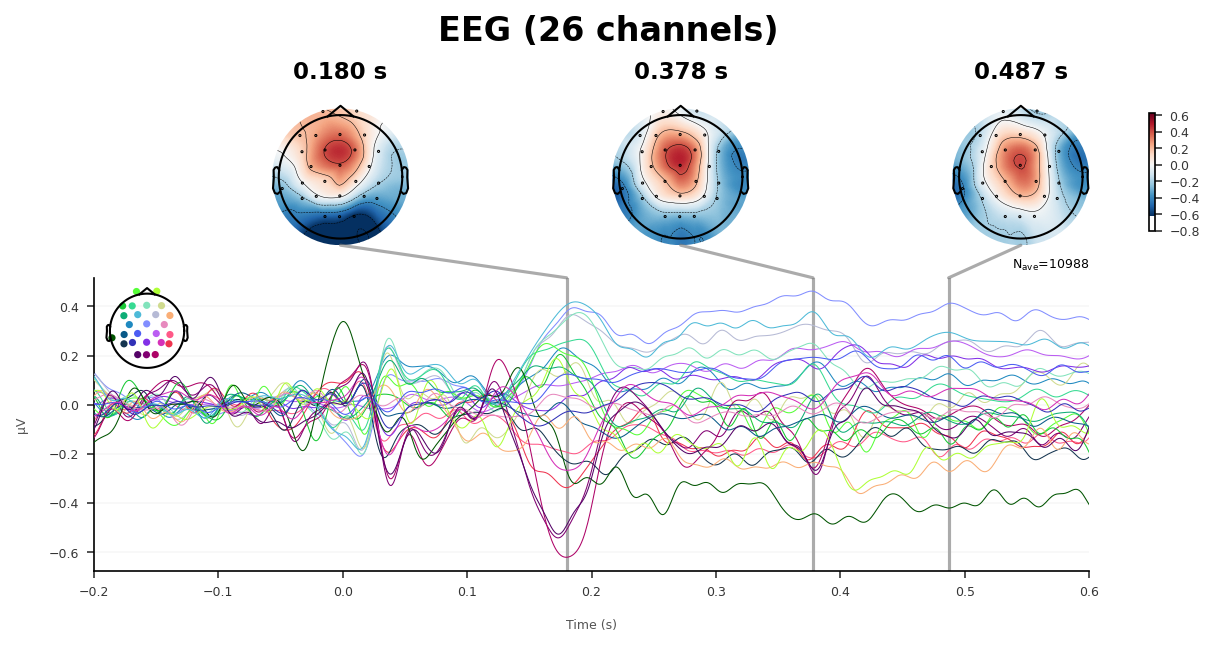

In [ ]:
epochs.average(picks = "eeg").plot_joint();

In [ ]:
# epochs.resample(sfreq=200)

export_path = RAW_DATA_PATH.joinpath(SESSION + "-epo.fif")

epochs.pick("eeg").save(export_path, overwrite = True)
print(f"[INFO] Exported epochs to {export_path}")

Overwriting existing file.
Overwriting existing file.
[INFO] Exported epochs to ../data/EEG/group13_own-epo.fif
